In [102]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from models.ICA_EM import CausalVarEM
import tqdm
import pandas as pd

In [159]:
n = 10000
def create_dataset(seed, model):
    np.random.seed(seed)
    coef_matrix = np.zeros((3,3))
    if model == "1":
        coef_matrix[1,0] = 1
        coef_matrix[2,0] = 1
        coef_matrix[2,1] = 1
        N_u = np.random.laplace(0, 1/np.sqrt(2), n)
        N_t = np.random.laplace(0, 1/np.sqrt(2), n)
        N_y = np.random.laplace(0, 1/np.sqrt(2), n)
    elif model == "2":
        coef_matrix[1,0] = 1
        coef_matrix[2,0] = -1
        coef_matrix[2,1] = 2
        N_u = np.random.laplace(0, 1/np.sqrt(2), n)
        N_t = np.random.laplace(0, 1/np.sqrt(2), n)
        N_y = np.random.laplace(0, 1/np.sqrt(2), n)
    mixing_matrix = np.linalg.inv(np.eye(3) - coef_matrix)
    X = mixing_matrix @ np.array([N_u, N_t, N_y])
    return {"treatment_effect": mixing_matrix[2,1], "data": X.T, "mixing_matrix": mixing_matrix}

In [160]:
out = create_dataset(2, "1")
out2 = create_dataset(2, "2")
print(out["mixing_matrix"])
print(out2["mixing_matrix"])


[[1. 0. 0.]
 [1. 1. 0.]
 [2. 1. 1.]]
[[ 1.  0.  0.]
 [ 1.  1. -0.]
 [ 1.  2.  1.]]


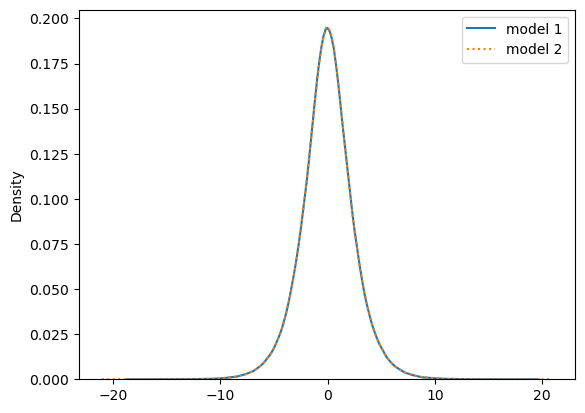

In [121]:
plt.figure()
sns.kdeplot(out["data"][:,2], label="model 1")
sns.kdeplot(out2["data"][:,2], label="model 2", linestyle='dotted')
plt.legend()
plt.show()

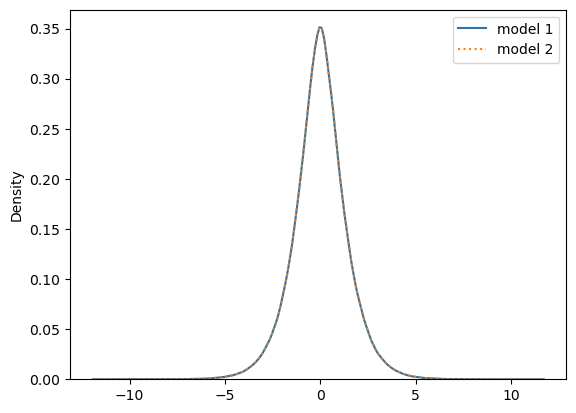

In [122]:
plt.figure()
sns.kdeplot(out["data"][:,1], label="model 1")
sns.kdeplot(out2["data"][:,1], label="model 2", linestyle='dotted')
plt.legend()

## Estimate mixing matrix for both outputs of the model

In [161]:
model1_est = []
model2_est = []
for i in tqdm.tqdm(range(100)):
    data1 = create_dataset(i, "1")
    data2 = create_dataset(i, "2")
    est = CausalVarEM(mode = "lower_triangular", max_iter = 20, random_seed = i)
    est.fit(data1["data"][:, [1,2]], J = 3, progress_bar=False)
    model1_est.append(est.A)
    est = CausalVarEM(mode = "lower_triangular", max_iter = 20, random_seed = i)
    est.fit(data2["data"][:, [1,2]], J = 3, progress_bar=False)
    model2_est.append(est.A)

treatment_effect1 = 1
treatment_effect2 = 2

100%|██████████| 100/100 [14:58<00:00,  8.98s/it]


In [162]:
model1 = pd.DataFrame({"confounder_col": [matrix[1,0] for matrix in model1_est],
                       "treatment_col": [matrix[1,1] for matrix in model1_est]})
model2 = pd.DataFrame({"confounder_col": [matrix[1,0] for matrix in model2_est],
                          "treatment_col": [matrix[1,1] for matrix in model2_est]})


In [163]:
#model1.to_csv("results/identifiability_model1.csv", index = False)
#model2.to_csv("results/identifiability_model2.csv", index = False)

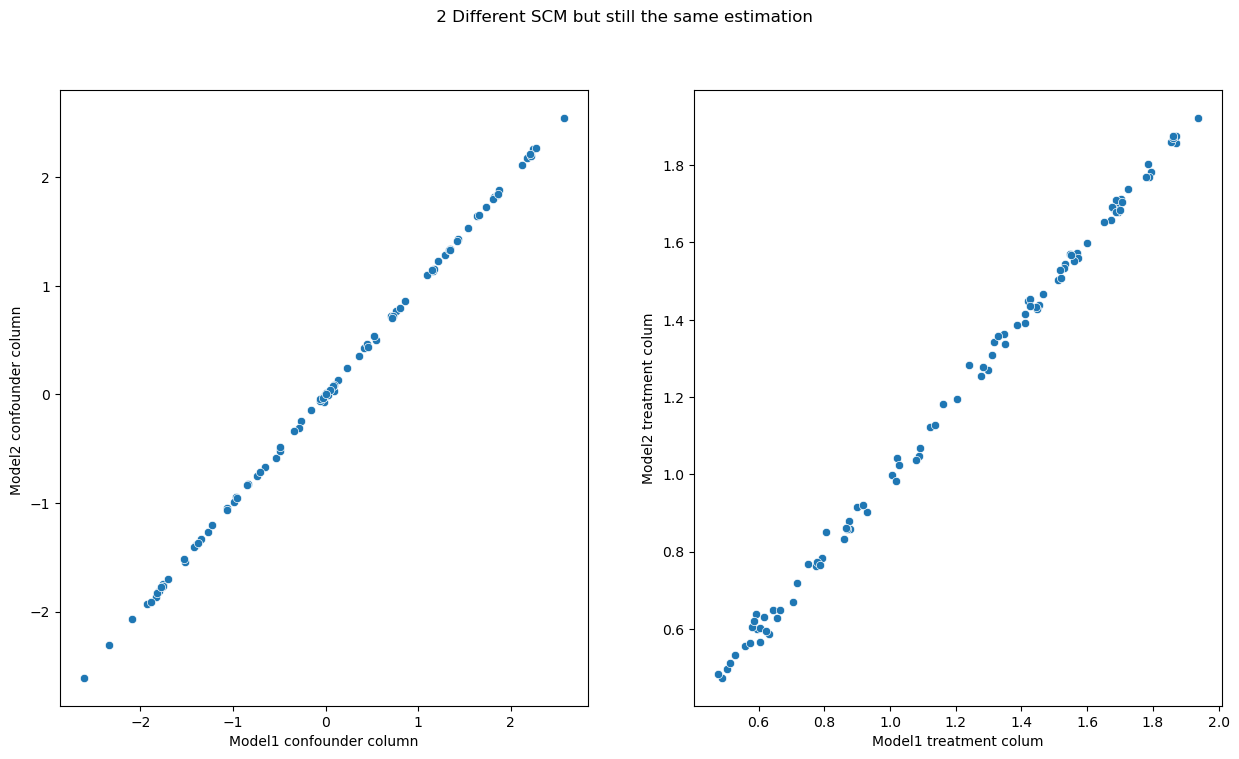

In [164]:
fig, ax =plt.subplots(1,2, figsize = (15,8))
sns.scatterplot(x = model1["confounder_col"], y = model2["confounder_col"], ax = ax[0])
ax[0].set_xlabel("Model1 confounder column")
ax[0].set_ylabel("Model2 confounder column ")

sns.scatterplot(x = model1["treatment_col"], y = model2["treatment_col"], ax = ax[1])
ax[1].set_xlabel("Model1 treatment colum")
ax[1].set_ylabel("Model2 treatment colum")
fig.suptitle(" 2 Different SCM but still the same estimation")
plt.show()

They are the same regardless of the dataset

In [175]:
# make violine plot and plot the true treatment effect
model1["id"] = model1.index
long_df = model1.melt(id_vars="id")

[]

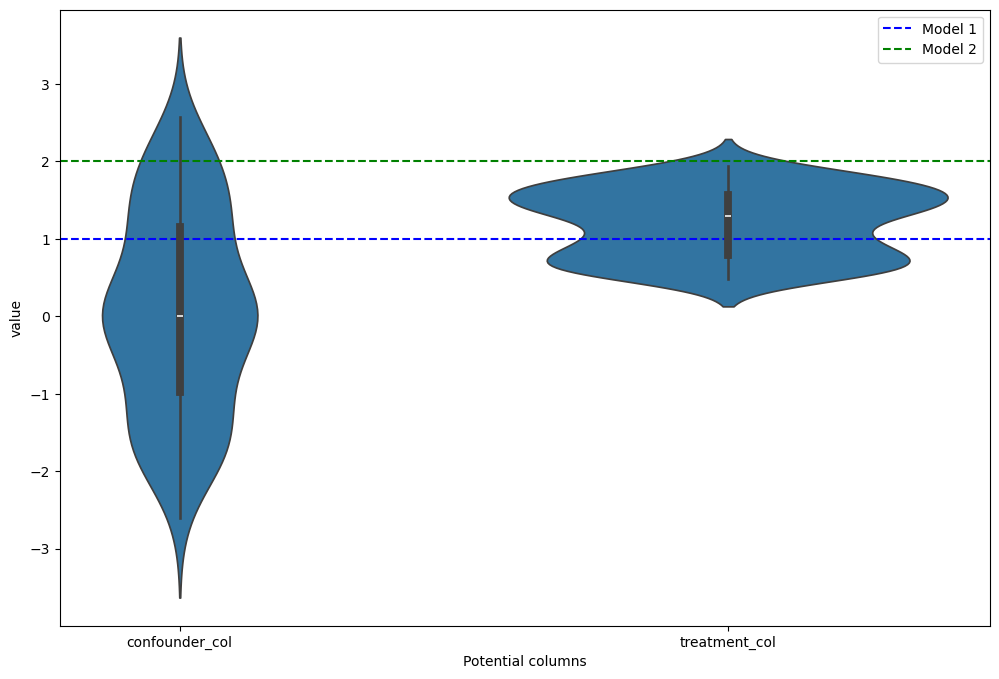

In [176]:
plt.figure(figsize=(12,8))
plt.axhline(y = 1, linestyle = "--", c = "b", label = "Model 1")
plt.axhline(y = 2, linestyle = "--", c = "g", label = "Model 2")

sns.violinplot(long_df, x = "variable",y = "value")
plt.xlabel("Potential columns")
plt.legend()
plt.plot()

# test different init

In [187]:
model_est = []
for i in tqdm.tqdm(range(100)):
    data = create_dataset(i, "1")
    est = CausalVarEM(mode = "lower_triangular", max_iter = 20, random_seed = i, init_range = [-3,-1])
    est.fit(data["data"][:, [1,2]], J = 3, progress_bar=False)
    model_est.append(est.A)
treatment_effect1 = 1


  1%|          | 1/100 [00:04<07:00,  4.25s/it]

In [ ]:
# make violine plot and plot the true treatment effect
df_long = pd.DataFrame({"confounder_col" : [mat[1,0] for mat in model_est],
                       "treatment_col": [mat[1,1] for mat in model_est]})
df_long["id"] = df_long.index
df_long = df_long.melt(id_vars="id")

[]

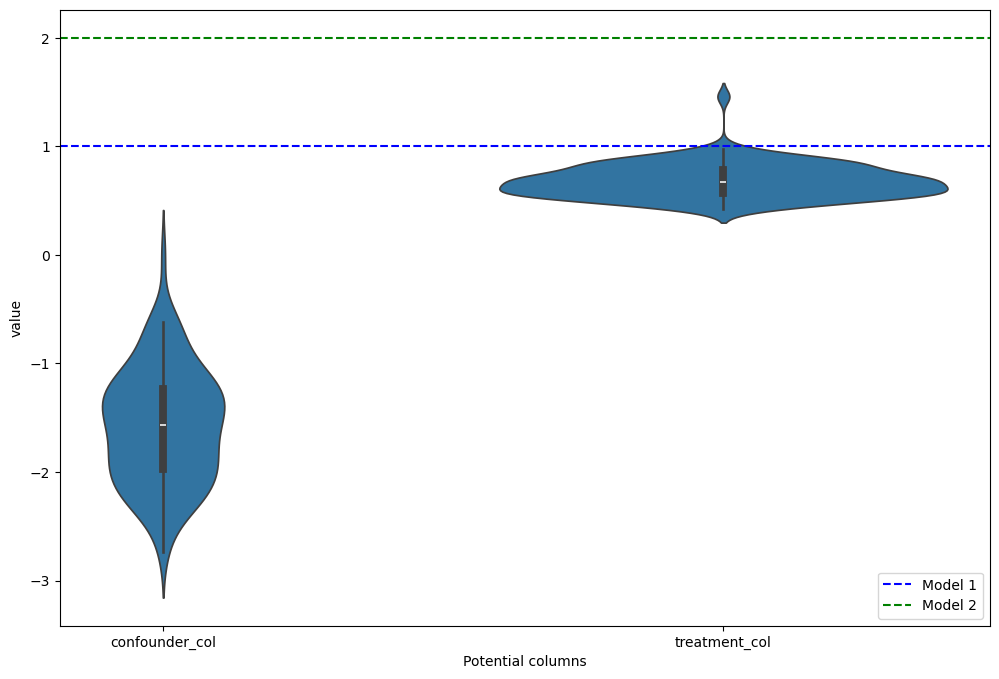

In [ ]:
plt.figure(figsize=(12,8))
plt.axhline(y = 1, linestyle = "--", c = "b", label = "Model 1")
plt.axhline(y = 2, linestyle = "--", c = "g", label = "Model 2")

sns.violinplot(df_long, x = "variable",y = "value")
plt.xlabel("Potential columns")
plt.legend()
plt.plot()